In [ ]:
%pip install -q pandas requests tqdm torch torchvision torchmetrics pillow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import requests
import os

import pandas as pd

landmarks = "https://s3.amazonaws.com/google-landmark/metadata/train.csv"
save_path = "./"
landmarks_path = os.path.join(save_path, 'train.csv')

if not os.path.exists(landmarks_path):
  response = requests.get(landmarks)
  with open(landmarks_path, "wb") as f:
    f.write(response.content)

df = pd.read_csv(landmarks_path, delimiter=",")
df = df.sort_values('landmark_id')
df = df.groupby('landmark_id')['url'].apply(list).reset_index()
print(df.shape)
df.head(5)

(203094, 2)


,landmark_id,url
0,0,[http://upload.wikimedia.org/wikipedia/commons...
1,1,[https://upload.wikimedia.org/wikipedia/common...
2,2,[https://upload.wikimedia.org/wikipedia/common...
3,3,[http://upload.wikimedia.org/wikipedia/commons...
4,4,[http://upload.wikimedia.org/wikipedia/commons...


In [ ]:
N_CLASSES = 40
MIN_IMG_COUNT = 150
MAX_IMG_COUNT = 200
dataset_name = 'cv1_dataset'

In [ ]:
import time
import os
import urllib

from tqdm import tqdm

class_counter = 0

for _, row in df.iterrows():
  if class_counter == N_CLASSES:
    break

  if len(row["url"]) > MIN_IMG_COUNT:
    urls = row["url"][:MAX_IMG_COUNT] if len(row["url"]) > MAX_IMG_COUNT else row["url"]
    for img_url in tqdm(urls, desc=f"Images for class: {class_counter}. landmark_id={row['landmark_id']}"):
      file_name = img_url.split("/")[-1]
      img_path = os.path.join(save_path, dataset_name, f"{row['landmark_id']}", file_name)
      if not os.path.exists(img_path):
        os.makedirs(os.path.join(save_path, dataset_name, f"{row['landmark_id']}"), exist_ok=True)
        try:
          time.sleep(1)
          urllib.request.urlretrieve(img_url, img_path)
        except Exception as e:
          if '429' in f'{e}':
            print(e)
            continue
    class_counter += 1


Images for class: 39. landmark_id=2215: 100%|██████████| 200/200 [00:00<00:00, 120821.09it/s]


In [ ]:
from collections import defaultdict

metadata = defaultdict(list)
class_counter = 0

for dir in os.listdir(os.path.join(save_path, dataset_name)):
  for file in os.listdir(os.path.join(save_path, dataset_name, dir)):
    metadata[class_counter].append(os.path.join(save_path, dataset_name, dir, file))
  class_counter += 1

In [ ]:
from sklearn.model_selection import train_test_split

train_data = {'class': [], 'path': []}
test_data = {'class': [], 'path': []}

for class_label, paths in metadata.items():
    train_paths, test_paths = train_test_split(paths, test_size=0.2, random_state=42)

    train_data['class'].extend([class_label] * len(train_paths))
    train_data['path'].extend(train_paths)

    test_data['class'].extend([class_label] * len(test_paths))
    test_data['path'].extend(test_paths)

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_df.head(5)

,class,path
0,0,./cv1_dataset/27/Isa_Khan_27s_Tomb_2C_Delhi_08...
1,0,./cv1_dataset/27/Isa_khan_tomb.jpg
2,0,./cv1_dataset/27/The_tomb_of_Isa_Khan_Niyazi_0...
3,0,./cv1_dataset/27/The_tomb_of_Isa_Khan_Niyazi_0...
4,0,./cv1_dataset/27/Isa_Khan_27s_Tomb_Delhi_bw-10...


In [ ]:
import torch
import PIL
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
from torchvision import tv_tensors

IMG_SIZE = (224, 224)
BATCH_SIZE = 128
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/cv_lab1_dataset.csv"
PIL.Image.MAX_IMAGE_PIXELS = 933120000

class LandmarksDataset(Dataset):
  def __init__(self, data, transform=None):
    self.path_label_pairs = [(row["path"], row["class"]) for _, row in data.iterrows()]

    self.transform = transform

  def __len__(self):
    return len(self.path_label_pairs)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_path, label = self.path_label_pairs[idx]
    image = tv_tensors.Image(Image.open(img_path).convert('RGB'))

    if self.transform:
      image = self.transform(image)

    return image, label

train_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = LandmarksDataset(train_df, transform=train_transforms)
val_dataset = LandmarksDataset(test_df, transform=val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, drop_last=False, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, drop_last=False, pin_memory=True)

/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from torchvision.models import resnet50
import torch.nn as nn

resnet_model = resnet50(weights="IMAGENET1K_V2", progress=True)

In [ ]:
for param in resnet_model.parameters():
   param.requires_grad = False

resnet_model.fc = nn.Sequential(nn.Dropout(), nn.Linear(resnet_model.fc.in_features, N_CLASSES))

In [ ]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import torch.optim as optim

def train(model, train_loader, val_loader, num_cls, lr=0.001, decay=1e-5, epochs=15, device="cuda"):
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    m_acc = MulticlassAccuracy(num_classes=num_cls).to(device)
    m_f1 = MulticlassF1Score(num_classes=num_cls).to(device)

    num_train_batches, num_val_batches = len(train_loader), len(val_loader)

    running_loss_train, running_loss_val, acc_val, f1_val = [], [], [], []
    max_f1 = 0.0

    for epoch in range(epochs):
        train_loss, val_loss, val_acc, val_f1 = 0, 0, 0, 0

        model.train()
        for image, label in tqdm(train_loader, desc=f"[Training] Epoch - {epoch}"):
            image = image.to(device)
            label = label.to(torch.int64).to(device)

            optimizer.zero_grad()
            output = model(image)

            curr_train_loss = loss_fn(output, label)

            curr_train_loss.backward()
            optimizer.step()

            train_loss += curr_train_loss.item()

        model.eval()
        with torch.no_grad():
            for image, label in tqdm(val_loader, desc=f"[Validation] Epoch - {epoch}"):
                image = image.to(device)
                label = label.to(torch.int64).to(device)

                output = model(image)
                val_loss += loss_fn(output, label).item()

                m_acc.update(output, label)
                val_acc += m_acc.compute().item()
                m_acc.reset()

                m_f1.update(output, label)
                val_f1 += m_f1.compute().item()
                m_f1.reset()

        running_loss_train.append(train_loss / num_train_batches)
        running_loss_val.append(val_loss / num_val_batches)
        acc_val.append(val_acc / num_val_batches)
        f1_val.append(val_f1 / num_val_batches)

        if f1_val[-1] > max_f1:
            print(f"[Save] Best checkpoint: {max_f1:.3f} -> {f1_val[-1]:.3f}")
            max_f1 = f1_val[-1]
            os.makedirs(os.path.join(save_path, "lab1_ckpt"), exist_ok=True)
            torch.save(model, os.path.join(save_path, "lab1_ckpt", f"resnet50_{max_f1:.3f}.pth"))

        if device == "cuda":
            torch.cuda.empty_cache()

        print(f"[Train] Loss: {running_loss_train[-1]:.6f}")
        print(f"[Val] Loss: {running_loss_val[-1]:.6f} | Acc: {acc_val[-1]:.3f} | F1: {f1_val[-1]:.3f}")
        print("-" * 40)

    return model

In [ ]:
resnet_model = train(resnet_model, train_dataloader, val_dataloader, num_cls=N_CLASSES, epochs=15)

[Training] Epoch - 0:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 0:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.000 -> 0.312
[Train] Loss: 3.381029
[Val] Loss: 3.104229 | Acc: 0.341 | F1: 0.312
----------------------------------------


[Training] Epoch - 1:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 1:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.312 -> 0.439
[Train] Loss: 2.820086
[Val] Loss: 2.654266 | Acc: 0.464 | F1: 0.439
----------------------------------------


[Training] Epoch - 2:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 2:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.439 -> 0.518
[Train] Loss: 2.443126
[Val] Loss: 2.348237 | Acc: 0.538 | F1: 0.518
----------------------------------------


[Training] Epoch - 3:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 3:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.518 -> 0.543
[Train] Loss: 2.162690
[Val] Loss: 2.129232 | Acc: 0.557 | F1: 0.543
----------------------------------------


[Training] Epoch - 4:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 4:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.543 -> 0.566
[Train] Loss: 1.904350
[Val] Loss: 1.969156 | Acc: 0.581 | F1: 0.566
----------------------------------------


[Training] Epoch - 5:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 5:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.566 -> 0.594
[Train] Loss: 1.750456
[Val] Loss: 1.826088 | Acc: 0.609 | F1: 0.594
----------------------------------------


[Training] Epoch - 6:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 6:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.594 -> 0.601
[Train] Loss: 1.601089
[Val] Loss: 1.727487 | Acc: 0.615 | F1: 0.601
----------------------------------------


[Training] Epoch - 7:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 7:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.601 -> 0.615
[Train] Loss: 1.526994
[Val] Loss: 1.645222 | Acc: 0.628 | F1: 0.615
----------------------------------------


[Training] Epoch - 8:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 8:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.615 -> 0.639
[Train] Loss: 1.399550
[Val] Loss: 1.559359 | Acc: 0.644 | F1: 0.639
----------------------------------------


[Training] Epoch - 9:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 9:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.639 -> 0.643
[Train] Loss: 1.359528
[Val] Loss: 1.497419 | Acc: 0.652 | F1: 0.643
----------------------------------------


[Training] Epoch - 10:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 10:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: Use

[Save] Best checkpoint: 0.643 -> 0.647
[Train] Loss: 1.271593
[Val] Loss: 1.467627 | Acc: 0.655 | F1: 0.647
----------------------------------------


[Training] Epoch - 11:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 11:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: Use

[Save] Best checkpoint: 0.647 -> 0.660
[Train] Loss: 1.215671
[Val] Loss: 1.427814 | Acc: 0.668 | F1: 0.660
----------------------------------------


[Training] Epoch - 12:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 12:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: Use

[Train] Loss: 1.150134
[Val] Loss: 1.392216 | Acc: 0.664 | F1: 0.654
----------------------------------------


[Training] Epoch - 13:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 13:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: Use

[Save] Best checkpoint: 0.660 -> 0.679
[Train] Loss: 1.109960
[Val] Loss: 1.334194 | Acc: 0.682 | F1: 0.679
----------------------------------------


[Training] Epoch - 14:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 14:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: Use

[Train] Loss: 1.098311
[Val] Loss: 1.317839 | Acc: 0.678 | F1: 0.669
----------------------------------------


In [ ]:
best_model = torch.load(os.path.join(save_path, "lab1_ckpt", f"resnet50_0.679.pth"))

best_model = train(best_model, train_dataloader, val_dataloader, num_cls=N_CLASSES, epochs=15, lr=0.003)

[Training] Epoch - 0:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 0:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.000 -> 0.666
[Train] Loss: 1.127339
[Val] Loss: 1.237153 | Acc: 0.668 | F1: 0.666
----------------------------------------


[Training] Epoch - 1:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 1:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.666 -> 0.680
[Train] Loss: 0.958018
[Val] Loss: 1.159985 | Acc: 0.690 | F1: 0.680
----------------------------------------


[Training] Epoch - 2:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 2:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.680 -> 0.702
[Train] Loss: 0.801192
[Val] Loss: 1.099889 | Acc: 0.703 | F1: 0.702
----------------------------------------


[Training] Epoch - 3:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 3:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.702 -> 0.712
[Train] Loss: 0.734788
[Val] Loss: 1.047911 | Acc: 0.718 | F1: 0.712
----------------------------------------


[Training] Epoch - 4:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 4:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.712 -> 0.718
[Train] Loss: 0.670172
[Val] Loss: 1.022225 | Acc: 0.720 | F1: 0.718
----------------------------------------


[Training] Epoch - 5:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 5:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.718 -> 0.732
[Train] Loss: 0.666569
[Val] Loss: 1.007477 | Acc: 0.731 | F1: 0.732
----------------------------------------


[Training] Epoch - 6:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 6:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Train] Loss: 0.601089
[Val] Loss: 0.998492 | Acc: 0.728 | F1: 0.723
----------------------------------------


[Training] Epoch - 7:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 7:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Save] Best checkpoint: 0.732 -> 0.735
[Train] Loss: 0.579741
[Val] Loss: 0.990708 | Acc: 0.738 | F1: 0.735
----------------------------------------


[Training] Epoch - 8:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 8:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Train] Loss: 0.558505
[Val] Loss: 0.965273 | Acc: 0.738 | F1: 0.735
----------------------------------------


[Training] Epoch - 9:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 9:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserW

[Train] Loss: 0.495016
[Val] Loss: 0.967683 | Acc: 0.733 | F1: 0.733
----------------------------------------


[Training] Epoch - 10:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 10:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: Use

[Save] Best checkpoint: 0.735 -> 0.745
[Train] Loss: 0.486903
[Val] Loss: 0.947515 | Acc: 0.750 | F1: 0.745
----------------------------------------


[Training] Epoch - 11:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 11:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: Use

[Train] Loss: 0.450503
[Val] Loss: 0.949702 | Acc: 0.745 | F1: 0.734
----------------------------------------


[Training] Epoch - 12:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 12:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: Use

[Train] Loss: 0.438072
[Val] Loss: 0.931807 | Acc: 0.738 | F1: 0.734
----------------------------------------


[Training] Epoch - 13:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 13:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: Use

[Train] Loss: 0.420458
[Val] Loss: 0.913404 | Acc: 0.747 | F1: 0.740
----------------------------------------


[Training] Epoch - 14:   0%|          | 0/11 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[Validation] Epoch - 14:   0%|          | 0/3 [00:00<?, ?it/s]/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: Use

[Train] Loss: 0.417945
[Val] Loss: 0.924623 | Acc: 0.734 | F1: 0.726
----------------------------------------


In [ ]:
img_batch, label_batch = next(iter(val_dataloader))

model = torch.load(os.path.join(save_path, "lab1_ckpt", f"resnet50_0.745.pth"), map_location="cpu")

model = model.to("cuda")
img_batch = img_batch = img_batch.to("cuda")

model.eval()
with torch.no_grad():
    output = model(img_batch).argmax(dim=1).squeeze()
    output = output.detach().cpu().numpy()

/home/mode_ac/anaconda3/envs/sco_age_verification/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

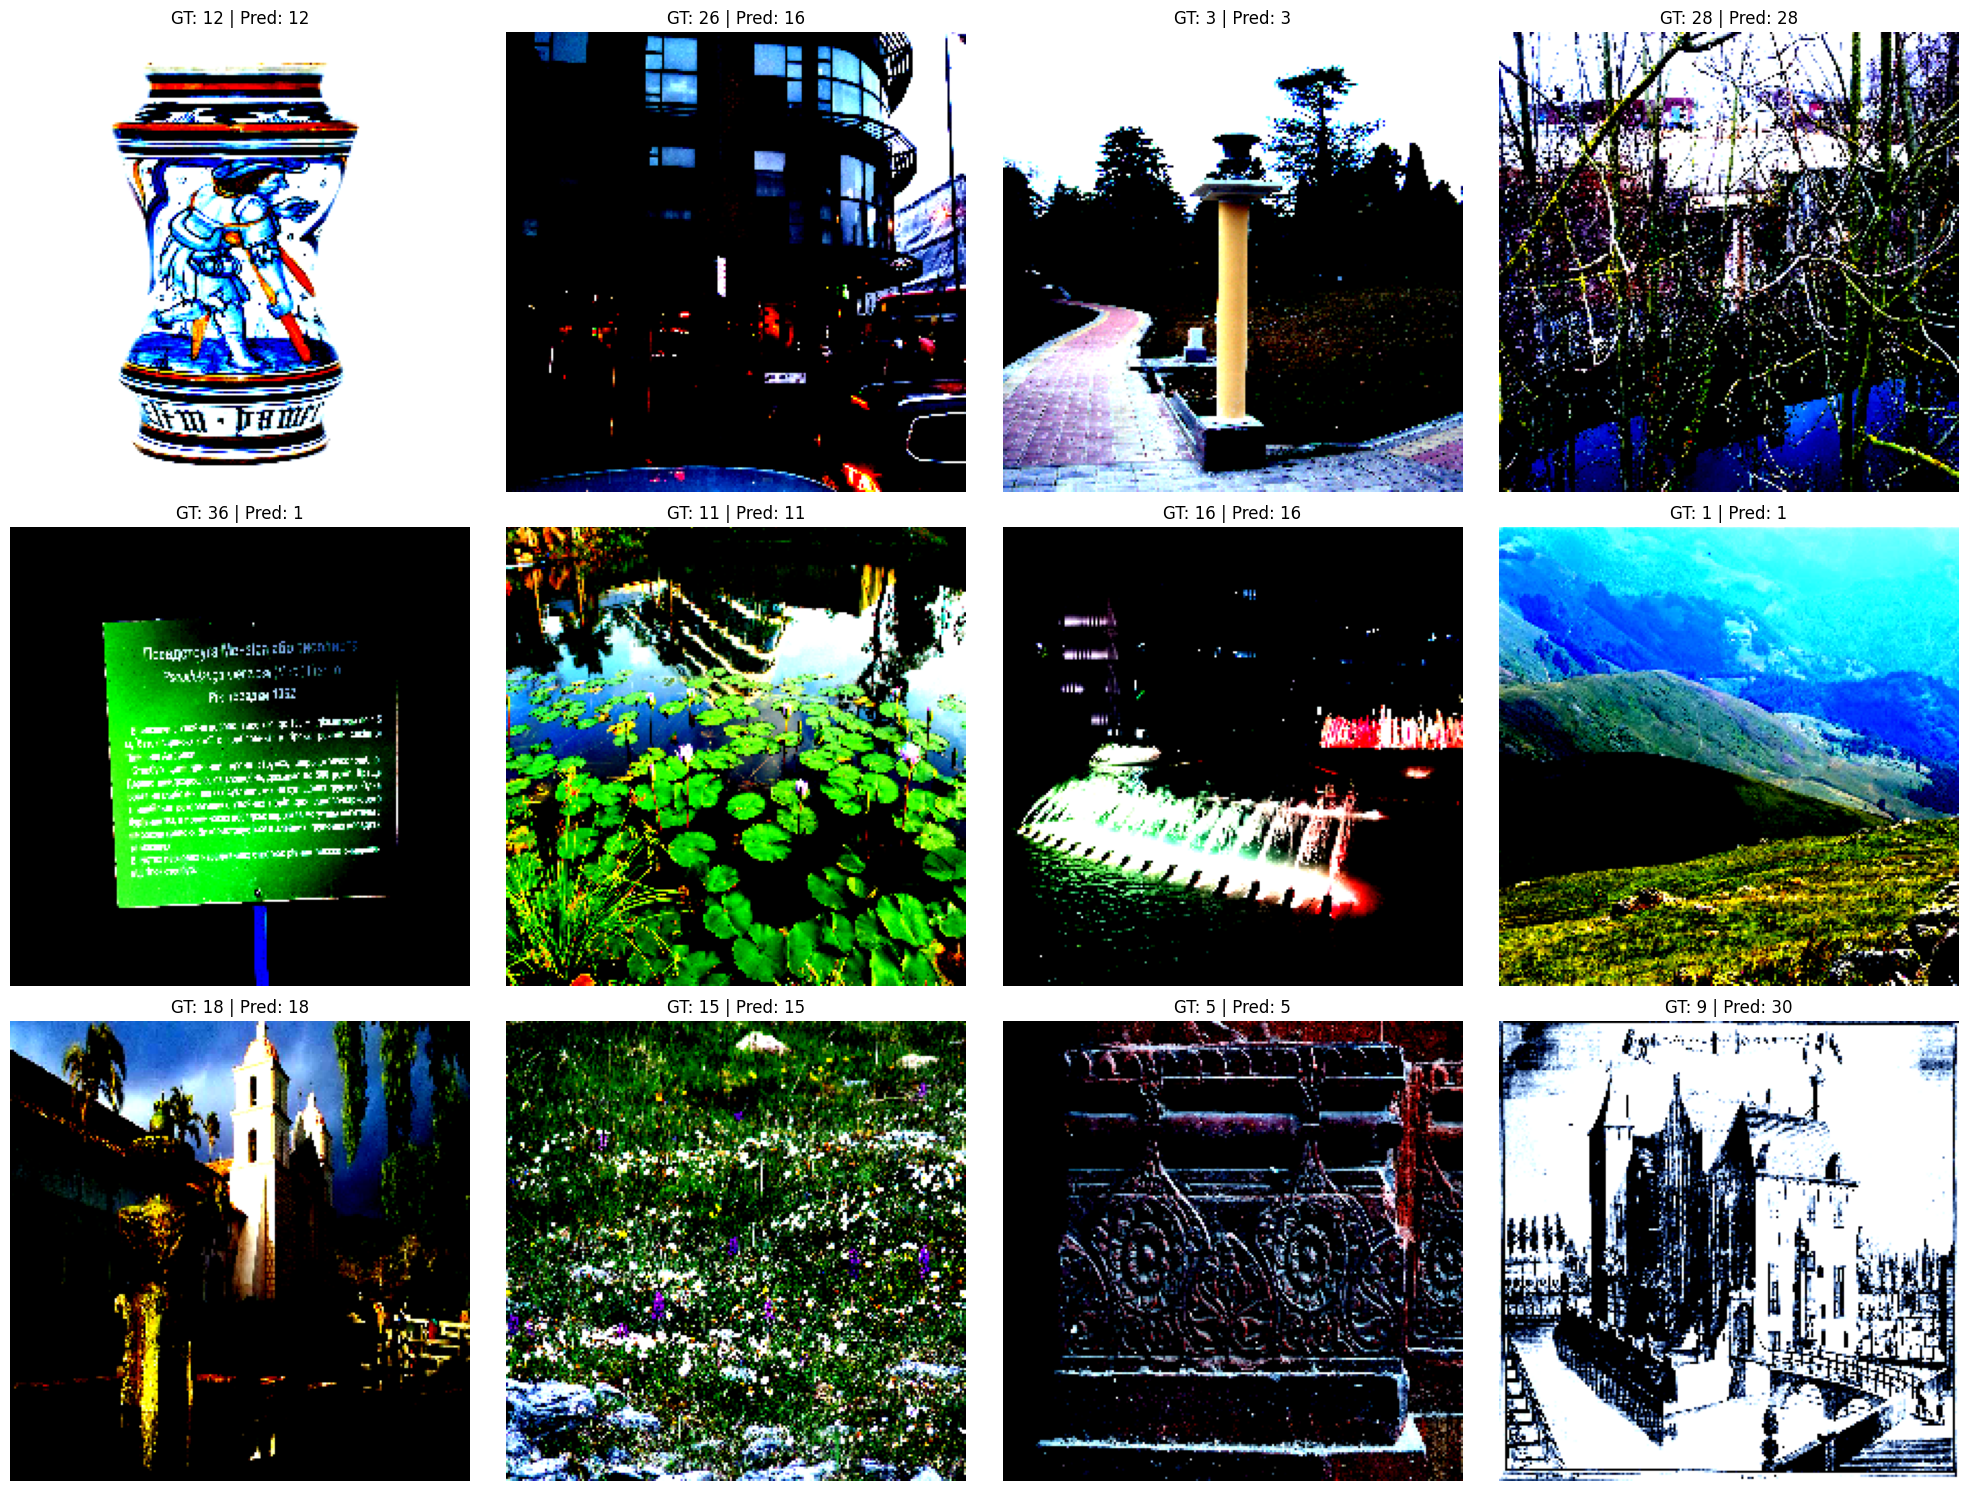

In [ ]:
import matplotlib.pyplot as plt

N = 12
img_batch = img_batch.permute(0, 2, 3, 1)[:N].cpu().numpy()
label_batch = label_batch[:N].numpy()

cols = 4
rows = (N + cols - 1) // cols

fig, ax = plt.subplots(rows, cols, figsize=(20, 5*rows))
ax = ax.flatten()

for i in range(N):
    ax[i].imshow(img_batch[i])
    ax[i].set_title(f"GT: {label_batch[i]} | Pred: {output[i]}")
    ax[i].axis('off')

for j in range(N, rows * cols):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()